In [103]:
import pandas as pd
import json
import subprocess
import re
import os
import shutil

In [104]:
class ArqManipulation:
    """
    A utility class for file operations and data manipulation.
    """

    @staticmethod 
    def read_parquet_file(parquet_file_name: str) -> pd.DataFrame:
        """
        Reads a Parquet file and returns a DataFrame.

        :param parquet_file_name: Path to the Parquet file.
        :return: DataFrame with file contents.
        """
        try:
            if not os.path.exists(parquet_file_name):
                print(f"File '{parquet_file_name}' does not exist.")
                return pd.DataFrame()
            
            return pd.read_parquet(parquet_file_name)
        except Exception as e:
            raise RuntimeError(f"Error reading Parquet file '{parquet_file_name}': {e}")

    @staticmethod
    def save_df_to_parquet(df: pd.DataFrame, parquet_file_name: str):
        """
        Saves a DataFrame to a Parquet file.

        :param df: Dataframe to save.
        :param parquet_file_name: Parqueet saving path.
        """
        try:
            os.makedirs(os.path.dirname(parquet_file_name), exist_ok=True)
            df.to_parquet(parquet_file_name)
            print(f"DataFrame successfully saved to {parquet_file_name}")
        except Exception as e:
            raise RuntimeError(f"Error saving DataFrame to Parquet file '{parquet_file_name}': {e}")

    @staticmethod
    def clean_ansi_escape(base_str: str) -> str:
        """
        Removes ANSI escape values from a string.

        :param base_str: Unformmated string.
        :return: Cleaned string.
        """
        return re.sub(r'\x1B\[[0-9;]*[A-Za-z]', '', base_str)

    @staticmethod
    def parse_stdout_json(base_str: str) -> dict:
        """
        Parses JSON output from GitHub CLI after cleaning ANSI escape sequences.

        :param base_str: The raw output string from the GitHub CLI.
        :return: Parsed JSON dictionary.
        """
        try:
            cleaned = ArqManipulation.clean_ansi_escape(base_str)
            str_output = ''.join(cleaned.splitlines())
            return json.loads(str_output)
        except json.JSONDecodeError as e:
            raise e

    @staticmethod
    def json_to_df(parsed_json: dict) -> pd.DataFrame:
        """
        Converts a JSON dictionary to a sorted DataFrame with specific columns.

        :param parsed_json: Parsed JSON data.
        :return: Pandas DataFrame sorted by the 'createdAt' column.
        """
        try:
            df_json = pd.DataFrame(parsed_json)
            required_columns = ['name', 'createdAt', 'conclusion', 'status', 'databaseId', 'workflowDatabaseId']
            
            if not all(col in df_json.columns for col in required_columns):
                raise KeyError(f"Missing required columns in JSON data: {set(required_columns) - set(df_json.columns)}")

            df_json['createdAt'] = pd.to_datetime(df_json['createdAt'])
            return df_json[required_columns].sort_values(by="createdAt")
        except KeyError as e:
            raise ValueError(f"Error processing JSON to DataFrame: {e}")
        except Exception as e:
            raise RuntimeError(f"Unexpected error in json_to_df: {e}")

In [105]:
class ActionsWorkflow:
    """
    A class to extract GitHub Actions workflows using the GitHub CLI, generating a dataframe with returned data
    """

    def __init__(self, repository, query_size):
        """
        Initializes the ActionsWorkflow class.

        :param repository: GitHub repository in the format "owner/repo".
        :param query_size: Number of workflows to retrieve.
        """
        self.repository = repository
        self.json_attributes = '--json name,status,conclusion,createdAt,databaseId,workflowDatabaseId'
        self.query_size = query_size
        self.df = self.__gh_list_query__()

    def __gh_list_query__(self):
        """
        Calls the GitHub API via the GitHub CLI (`gh run list`) and retrieves
        a specified number of workflows.

        :return: A DataFrame containing the parsed workflow data.
        """
        try:
            list_command = f'gh run --repo {self.repository} list {self.json_attributes} -L {self.query_size}'
            
            output_json = subprocess.run(
                list_command, shell=True, text=True, check=True, capture_output=True
            ).stdout

            parsed_json = ArqManipulation.parse_stdout_json(output_json)
            df = ArqManipulation.json_to_df(parsed_json)

            ArqManipulation.save_df_to_parquet(df = df, parquet_file_name="./bin/actionsWorflow.parquet")

            return df.set_index('name')

        except subprocess.CalledProcessError as e:
            print(f"Error executing GitHub CLI command: {e}")
            return pd.DataFrame()  # Return an empty DataFrame on error



In [151]:
class ActionsJobs:
    """
    A class to interact with GitHub Actions jobs using the GitHub CLI.
    """

    def __init__(self, repository, workflow):
        """
        Initializes the ActionsJobs class.

        :param repository: GitHub repository in the format "owner/repo".
        :param workflow: Workflow associated with the jobs.
        """
        self.repository = repository
        self.workflow = workflow  

    def __split_string__(self, job):
        """
        Splits a job string into structured components.

        :param job: The job string to split.
        :return: A list of cleaned job attributes.
        """
        delimiters = r" \| | / build in | \(ID |\| in| / cleanup in | /" 
        splitted_job = re.split(delimiters, job)
        splitted_job = [s.strip() for s in splitted_job if s.strip()]

        return splitted_job


    def __clean_job_text__(self, base_str: str) -> pd.DataFrame:
        """
        Cleans and structures GitHub job data from CLI output.

        :param base_str: Raw job text output from the GitHub CLI.
        :return: A Pandas DataFrame with structured job data.
        """
        try:
            # Remove ANSI escape sequences and unwanted characters
            ansi_cleaned = ArqManipulation.clean_ansi_escape(base_str)
            cleaned = ansi_cleaned.replace("✓", "PASSED |").replace("X", "FAILED |")
            
            # Extract job details section
            start_index = cleaned.find("JOBS")
            end_index = cleaned.find("ANNOTATIONS")
            if start_index == -1 and end_index == -1:
                print("Warning: JOBS or ANNOTATIONS section not found in output.")
                return pd.DataFrame()

            cleaned_list = cleaned[start_index:end_index].splitlines()

            # Define columns
            columns = ["Conclusion", "Test", "Build_Time", "Job_Id"]
            jobs_df = pd.DataFrame(columns=columns)
            jobs_df["Failed_At"] = None

            for job in cleaned_list:
                if "ID" in job and ("PASSED" in job or "FAILED" in job):
                    temp_df = pd.DataFrame([self.__split_string__(job)], columns=columns)
                    temp_df['Build_Time'] = str_time_to_int(temp_df['Build_Time'].get(0))

                    #temp_df['Build_Time'] = pd.to_datetime(temp_df['Build_Time'], format="%Hh%Mm%Ss%f", errors='coerce').dt.time  

                    jobs_df = pd.concat([jobs_df, temp_df], ignore_index=True)
                
                elif "FAILED" in job:
                    failed = job.split("FAILED | ")
                    if not jobs_df.empty:
                        jobs_df.at[jobs_df.index[-1], "Failed_At"] = failed[1]  

            jobs_df["Job_Id"] = jobs_df["Job_Id"].str.replace(")", "", regex=False).astype('int')

            return jobs_df

        except Exception as e:
            print(f"Error processing job text: {e}")
            return pd.DataFrame()

    def get_jobs(self, database_id):
        """
        Retrieves job data from the GitHub CLI and processes it.

        :param database_id: The ID of the workflow run.
        :return: A Pandas DataFrame containing job details.
        """
        try:
            jobs_df = ArqManipulation.read_parquet_file(parquet_file_name="./bin/actionsJobs.parquet")
            if jobs_df.empty or not database_id in jobs_df['Database_Id'].values:
                command = f'gh run --repo {self.repository} view {database_id}'
                jobs_data = subprocess.run(command, shell=True, text=True, check=True, capture_output=True).stdout
                jobs_data = self.__clean_job_text__(jobs_data)

                jobs_df = pd.concat([jobs_df, jobs_data], ignore_index=True)

                if not jobs_df.empty:
                    jobs_df["Database_Id"] = int(database_id)
                ArqManipulation.save_df_to_parquet(jobs_df, parquet_file_name="./bin/actionsJobs.parquet")

            return jobs_df

        except subprocess.CalledProcessError as e:
            print(f"Error executing GitHub CLI command: {e}")
            return pd.DataFrame()

        except Exception as e:
            print(f"Unexpected error: {e}")
            return pd.DataFrame()

def str_time_to_int(time_str):
    names = ['d', 'h', 'm', 's']
    seconds = [86400, 3600, 60, 1]

    total_time = 0

    for m, t in zip(names,seconds):
        if m in time_str:
            time_list = time_str.split(m)
            total_time +=  int(time_list[0]) * t
            time_str = time_list[1]

    return total_time


In [107]:
class ActionsArtifacts:
    """
    A class to handle downloading, retrieving, and deleting GitHub Actions artifacts.
    """

    def __init__(self, repository: str):
        """
        Initializes the ActionsArtifacts object.

        :param repository: The GitHub repository in the format "owner/repo".
        """
        self.repository = repository
        self.folder = './artifacts/'  # Default storage dir
        self.paths = self.retrieve_downloaded_artifacts() 

    def download_artifact(self, database_id: str):
        """
        Downloads an artifact from GitHub Actions using the GitHub CLI.

        :param database_id: The database ID of the artifact to download.
        """
        try:
            # Ensure the folder exists before downloading
            os.makedirs(self.folder, exist_ok=True)

            # Construct the command to download the artifact
            command = f'gh run --repo {self.repository} download {database_id} --dir {os.path.join(self.folder, str(database_id))}'

            # Execute the command
            subprocess.run(command, shell=True, text=True, check=True)
            print("Download Successful")
        except subprocess.CalledProcessError as e:
            print(f"Error during artifact download: {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")

    def retrieve_downloaded_artifacts(self) -> list[str]:
        """
        Retrieves all downloaded artifacts file paths.

        :return: returns Paths of the downloaded artifacts
        """
        paths = []

        # Walk through the artifacts folder and collect all file paths
        for path, _, files in os.walk(self.folder):
            for file in files:
                paths.append(os.path.join(path, file))

        return paths

    def delete_downloaded_artifacts(self):
        """
        Deletes all downloaded artifacts recursively
        """
        try:
            shutil.rmtree(self.folder)
            if os.path.exists(self.folder):
                print("Error: Failed to delete artifacts directory.")
            else:
                print("Artifacts directory deleted successfully.")
        except FileNotFoundError:
            print("Artifacts directory not found, nothing to delete.")
        except Exception as e:
            print(f"Error while deleting artifacts: {e}")


In [108]:
class PytestArtifactLogExtractor:
    """
    A class to extract and process test status and timing information from a pytest artifact log.
    """

    def __init__(self, path: str):
        """
        Initializes the PytestArtifactLogExtractor object.

        :param path: Path to the pytest artifact log file.
        """
        self.path = path
        self.data = self.__read_file__()

    def __read_file__(self):
        """
        Reads the contents of the log file and returns it as a string.

        :return: String containing the file content.
        """
        with open(self.path, "r") as file: 
            data = file.read()

        return data

    def log_to_df(self):
        """
        Parses the log file to extract test results and performance metrics.

        :return: A DataFrame combining test statuses with time metrics.
        """
        # Splitting log data based on "=" or new lines, while stripping whitespace
        splitted_data = [s.strip() for s in re.split(r"=|\n", self.data) if s.strip()]
        tests = []

        # Extracting test names and statuses (PASSED, ERROR, FAILED)
        for line in splitted_data:
            if 'PASSED' in line or 'ERROR' in line or 'FAILED' in line:
                splitting = re.split(r"%]| |::", line)[-3:]  # Extracting relevant parts
                tests.append(splitting)

        # Creating a DataFrame for test statuses
        status_df = pd.DataFrame(tests, columns=["status", "category", "name"])
        status_df = status_df.set_index('name')

        # Extracting time-related metrics from the log
        times_df = self.__extract_time_metrics__()

        # Merging the test status DataFrame with the time metrics DataFrame
        return self.__merge_artifact_dfs__(times_df=times_df, status_df=status_df)
                
    def __extract_time_metrics__(self):
        """
        Extracts test execution time metrics from the log file.

        :return: A list of DataFrames containing various test timing metrics.
        """
        values = self.data.splitlines()
        header = []
            
        for value in values:
            if 'grand total' in value or 'passed in' in value:
                continue    
            elif '=' in value: # Divide by headers demarked by '='
                value = value.replace("=", "")  
                header.append([value]) 
            else:
                value_split = re.split(r"\s+", value) 
                if header:  
                    header[-1].append(value_split)  # Append data to the last added section


        header.pop(0)  # Removing the first section, which contains test statuses

        # Convert extracted values into DataFrames
        time_dfs = self.__create_df__(header)

        return time_dfs

    def __create_df__(self, values):
        """
        Converts extracted timing information into DataFrames.

        :param values: A list of lists containing extracted time metrics.
        :return: A list of DataFrames with execution time statistics.
        """
        dfs = []
        
        for h in values:
            headers = list(filter(None, h[1]))  # Removing empty strings from headers
            time_df = pd.DataFrame(h[2:], columns=headers)

            if 'name' in time_df.columns:
                time_df = time_df.set_index('name') 
            
            # Converting time-related columns to datetime.time format
            time_columns = ['avg', 'min', 'total']
            for col in time_columns:
                if col in time_df.columns:
                    time_df[col] = pd.to_datetime(time_df[col], format="%H:%M:%S.%f", errors='coerce').dt.time  

            # Assigning a 'durationType' column for metric categorization
            time_df['durationType'] = h[0].replace('top', '').replace('test', '')

            dfs.append(time_df.copy()) 

        return dfs

    def __extract_self_path_info__(self):
        """
        Extracts test and database ID information from the log file path.

        :return: A DataFrame containing 'test' and 'databaseId' information.
        """
        stripped = self.path.split('/')[-1].split('.') 
        stripped.pop(len(stripped)-1)  # Removing the file extension

        return pd.DataFrame(stripped, index=['test', 'databaseId']).T

    def __merge_artifact_dfs__(self, times_df, status_df):
        """
        Merges test execution time data with test status information.

        :param times_df: A list of DataFrames containing time-related data.
        :param status_df: A DataFrame containing test statuses.
        :return: A combined DataFrame containing execution metrics and test results.
        """
        databaseId_df = self.__extract_self_path_info__()  
        order = ['category', 'durationType', 'databaseId', 'status', 'num', 'avg', 'min', 'total']
        dfs = []

        for h in times_df:
            joined_df = h.join(status_df)  # Merging time metrics with test statuses

            # Adding database ID to each row
            for col in databaseId_df.columns.values:
                joined_df[col] = databaseId_df[col].values[0]  

            # Reordering columns
            joined_df = joined_df[order]  
            dfs.append(joined_df)

        return pd.concat(dfs)  


### "Main"

In [123]:
repo_path = 'MagaluCloud/s3-specs'
query_size = 10

workflow = ActionsWorkflow(repository=repo_path, query_size=query_size)
workflow.df

DataFrame successfully saved to ./bin/actionsWorflow.parquet


,createdAt,conclusion,status,databaseId,workflowDatabaseId
name,,,,,
Pull Request Essential Tests,2025-02-06 20:44:29+00:00,success,completed,13187564806,132962917
Pull Request Extra Tests,2025-02-06 20:44:29+00:00,failure,completed,13187564801,142271933
Pull Request Extra Tests,2025-02-06 20:58:54+00:00,failure,completed,13187766356,142271933
Pull Request Essential Tests,2025-02-06 20:58:54+00:00,success,completed,13187766354,132962917
Pull Request Extra Tests,2025-02-06 21:15:14+00:00,success,completed,13188025727,142271933
Pull Request Essential Tests,2025-02-06 21:15:14+00:00,success,completed,13188025723,132962917
Pull Request Essential Tests,2025-02-06 21:17:53+00:00,success,completed,13188066466,132962917
Pull Request Extra Tests,2025-02-06 21:17:53+00:00,success,completed,13188066458,142271933
Pull Request Extra Tests,2025-02-07 13:53:28+00:00,,in_progress,13201233410,142271933


In [152]:
jobs = ActionsJobs(repo_path, workflow)
jobs.get_jobs(13187766354)

,Conclusion,Test,Build_Time,Job_Id,Failed_At,Database_Id
0,FAILED,run-tests,2403,36095602976,Run tests acl_test.py,13187766354
1,FAILED,run-tests,80,36095628929,None,13187766354
2,FAILED,run-tests,2338,36095670061,Run tests acl_test.py,13187766354
3,FAILED,run-tests,487,36120875486,Run tests acl_test.py,13187766354
4,FAILED,run-tests,464,36120821766,Run tests acl_test.py,13187766354
...,...,...,...,...,...,...
115,PASSED,"extra_tests_dist (acl, ../params/br-ne1.yaml)",648,36813211707,None,13187766354
116,PASSED,"extra_tests_debug (locking, ../params/br-ne1.y...",309,36813212060,None,13187766354
117,FAILED,"extra_tests_dist (bucket_versioning, ../params...",153,36813212311,Run tests *_test.py,13187766354
118,PASSED,"extra_tests_dist (policy, ../params/br-ne1.yaml)",194,36813212598,None,13187766354


In [110]:
artifacts = ActionArtifacts(repository=repo_path)
artifacts.download_artifact(13160019050)
a = artifacts.retrieve_downloaded_artifacts()

error downloading output_artifact_not_cli_and_locking_ne1.13160019050: error extracting zip archive: error extracting "pytest_output_not_cli_and_locking_ne1.13160019050.log": open /home/henrique.luis/repos/gh-Actions-Reader/artifacts/13160019050/output_artifact_not_cli_and_locking_ne1.13160019050/pytest_output_not_cli_and_locking_ne1.13160019050.log: file exists


TypeError: exceptions must derive from BaseException

In [100]:
artifact = PytestArtifactLogExtractor(path = a[1])
artifact.log_to_df()

,category,durationType,databaseId,status,num,avg,min,total
name,,,,,,,,
versioned_bucket_with_one_object,NaN,fixture duration,13160019050,NaN,3,00:00:06.876868,00:00:06.814098,00:00:20.570232
versioned_bucket_with_lock_config,NaN,fixture duration,13160019050,NaN,3,00:00:04.122805,00:00:03.946036,00:00:12.286554
lockeable_bucket_name,NaN,fixture duration,13160019050,NaN,1,00:00:02.321122,00:00:02.321122,00:00:02.321122
existing_bucket_name,NaN,fixture duration,13160019050,NaN,1,00:00:01.900853,00:00:01.900853,00:00:01.900853
s3_client,NaN,fixture duration,13160019050,NaN,5,00:00:00.079812,00:00:00.065131,00:00:00.846908
bucket_with_lock,NaN,fixture duration,13160019050,NaN,1,00:00:00.399650,00:00:00.399650,00:00:00.399650
test_verify_object_retention,locking_test.py,call duration,13160019050,PASSED,1,00:00:01.592751,00:00:01.592751,00:00:01.592751
test_verify_object_lock_configuration,locking_test.py,call duration,13160019050,PASSED,1,00:00:01.329674,00:00:01.329674,00:00:01.329674
test_simple_delete_with_lock,locking_test.py,call duration,13160019050,PASSED,1,00:00:00.919780,00:00:00.919780,00:00:00.919780


# Plotting

## Workflow Df

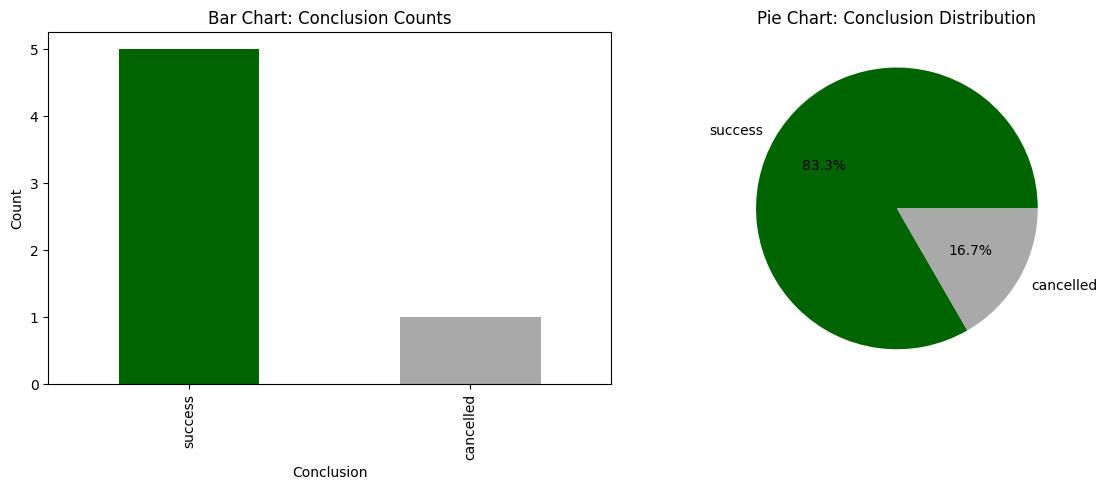

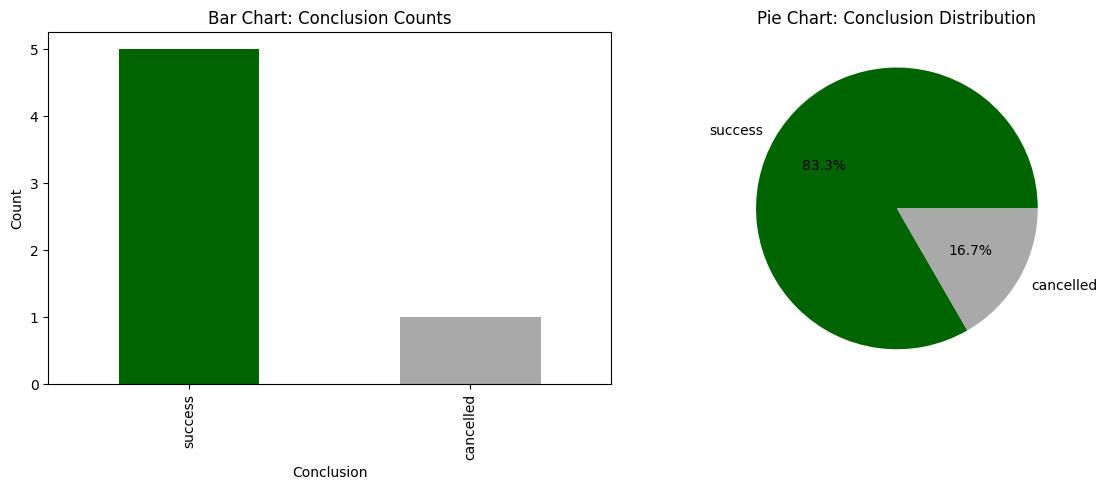

In [230]:
import matplotlib.pyplot as plt

# Define color mapping
colors = {
    'failure': 'firebrick',
    'cancelled': 'darkgray',
    'startup_failure': 'darkorange',
    'success':  'darkgreen'
}

# Filter the DataFrame
a = workflow.df[workflow.df['status'] == 'completed']

# Get value counts of the 'conclusion' columnimport matplotlib.pyplot as plt

# Define color mapping
colors = {
    'failure': 'firebrick',
    'cancelled': 'darkgray',
    'startup_failure':'darkorange',
    'success':  'darkgreen'

}

# Filter the DataFrame
a = workflow.df[workflow.df['status'] == 'completed']

# Get value counts of the 'conclusion' column
value_counts = a['conclusion'].value_counts()

# Map colors to the categories in value_counts
bar_colors = [colors[cat] for cat in value_counts.index]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the bar chart on the first subplot
value_counts.plot.bar(color=bar_colors, ax=ax1)
ax1.set_xlabel('Conclusion')
ax1.set_ylabel('Count')
ax1.set_title('Bar Chart: Conclusion Counts')

# Plot the pie chart on the second subplot
value_counts.plot.pie(colors=bar_colors, autopct='%1.1f%%', ax=ax2)
ax2.set_ylabel('')  # Remove the y-label for the pie chart
ax2.set_title('Pie Chart: Conclusion Distribution')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()
value_counts = a['conclusion'].value_counts()

# Map colors to the categories in value_counts
bar_colors = [colors[cat] for cat in value_counts.index]

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the bar chart on the first subplot
value_counts.plot.bar(color=bar_colors, ax=ax1)
ax1.set_xlabel('Conclusion')
ax1.set_ylabel('Count')
ax1.set_title('Bar Chart: Conclusion Counts')

# Plot the pie chart on the second subplot
value_counts.plot.pie(colors=bar_colors, autopct='%1.1f%%', ax=ax2)
ax2.set_ylabel('')  # Remove the y-label for the pie chart
ax2.set_title('Pie Chart: Conclusion Distribution')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

## Jobs Df

In [231]:
jobs = ActionsJobs(repository=repo_path, workflow=workflow)
ids = workflow.df['databaseId'].unique()
all_job_dfs = [jobs.get_jobs(id)for id in ids]
jobs_df = pd.concat(all_job_dfs)
jobs_df

,Conclusion,Test,Build_Time,Job_Id,Failed_At,Database_Id
0,FAILED,run-tests,2403,36095602976,Run tests acl_test.py,13121837959
1,FAILED,run-tests,80,36095628929,None,13121837959
2,FAILED,run-tests,2338,36095670061,Run tests acl_test.py,13121837959
3,FAILED,run-tests,487,36120875486,Run tests acl_test.py,13121837959
4,FAILED,run-tests,464,36120821766,Run tests acl_test.py,13121837959
...,...,...,...,...,...,...
109,PASSED,run_tests (basic),97,36604837994,None,13121837959
110,FAILED,run_tests (bucket_versioning),338,36604838402,Run tests *_test.py,13121837959
111,PASSED,run_tests (cold_storage),73,36604838786,None,13121837959
112,PASSED,run_tests (presign),71,36604839217,None,13121837959


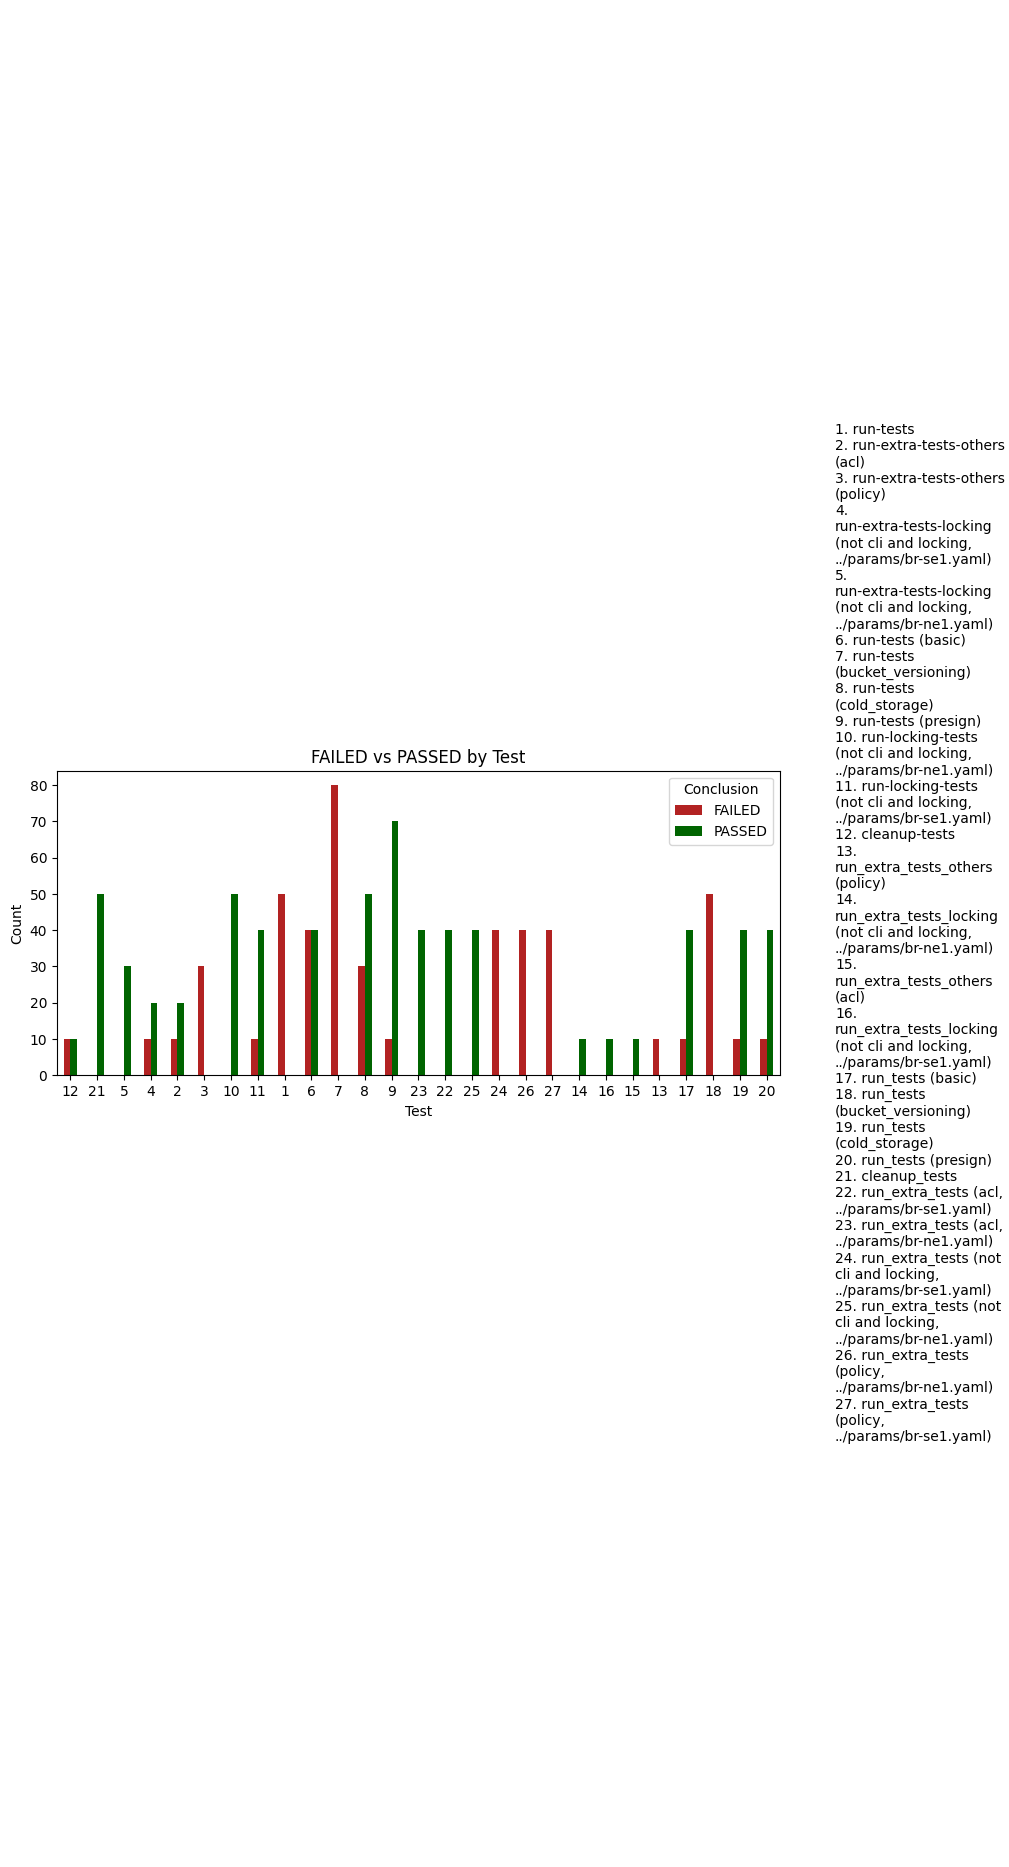

In [232]:
import matplotlib.pyplot as plt

def plot_failed_passed_jobs_bars(df):
    unique_names = df.groupby(['Test', 'Conclusion']).size().unstack(fill_value=0)
    test_to_number = {test: i + 1 for i, test in enumerate(df['Test'].unique())}

    # Define colors for 'FAILED' and 'PASSED'
    colors = {
        'FAILED': 'firebrick',
        'PASSED': 'darkgreen'
    }

    ax = unique_names.plot.bar(color=[colors['FAILED'], colors['PASSED']], figsize=(8, 4))

    # Add labels and title
    ax.set_xlabel('Test')
    ax.set_ylabel('Count')
    ax.set_title('FAILED vs PASSED by Test')

    # Change the x-tick labels to their respective numbers
    ax.set_xticklabels([test_to_number[test] for test in unique_names.index], rotation=0)

    # Create a legend for the test numbers and names
    test_legend = [f"{num}. {test}" for test, num in test_to_number.items()]
    plt.figtext(1.05, 0.5, "\n".join(test_legend), va='center', fontsize=10, wrap=True)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage
#plot_failed_passed_jobs_bars(jobs_df[jobs_df['Conclusion'] == 'FAILED'])
plot_failed_passed_jobs_bars(jobs_df)